# Exam Winter 2023

*Emanuel Buttaci* **s308589**,
*Giacomo Rosso* **s309273**

## Table of contents
0. [Abstract](#p0)
1. [Problem overview](#p1)
2. [Data exploration](#p2)
    1. [Audio recordings exploration](#p2are)
    2. [Target inspection](#p2ti)
3. [Preprocessing](#p3)
3. [Feature extraction](#p4)
    1. [Statistical features](#psf)
    2. [Time domain features](#ptf)
    3. [Frequency domain features](#pff)
4. [Classification](#p5)
    1. [Feature selection](#pfs)
    2. [Implementation of feed forward neural network](#pifnn)
    3. [Performance evaluation](#ppe)
5. [Optimization](#p6)
    1. [Random forest classifier](#prfc)
    2. [Gradient boosting classifier](#pgbc)
    3. [Feedforward neural network](#pfnnc)
6. [Results](#p6)
    1. [Submission](#ps)
7. [Discussion](#p7)
8. [References](#p8)

## Abstract <a name="p1"></a>

In this project we are dealing with audio recording classification regarding speakers’ commands for voice assistants. Our approach relies on the extraction of statistical features, time domain features and frequency domain features from audio recordings, subject to proper preprocessing. The choice of machine learning models mainly fall onto ensemble classifiers and neural network, which indeed turn out to be the outperformers among all classifiers, when properly tuned. In the end, our strategy is capable of delivering a score ranging from 77% to 94% on the provided evaluation set, which highlights the successfulness of our approach.

## Problem overview <a name="p1"></a>

Audio classification has been a much investigated topic in the last decades. In this project we are dealing with a dataset of audio recordings of several people with different characteristics. These recordings represent command for a voice assistant like Alexa. The objective is to recognize which commands are expressed in each audio recording, that is a classification problem. The dataset is divided into development set, which contains about 9854 **labeled** records, and evaluation set, which contains about 1455 **unlabeled** entries and will be subject to our classification pipeline.

In [ ]:
%pip install matplotlib numpy seaborn sklearn librosa scipy antropy soxr samplerate tensorflow keras

In [6]:
%config InlineBackend.figure_formats = ['svg', 'pdf']
%matplotlib inline
import json
import numpy as np
import pandas as pd
import time
# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# these are for signal preprocessing and features extraction
import librosa
import librosa.display
import librosa.effects
import scipy.fft as fft
import scipy.io.wavfile
import scipy.stats as stats
from scipy.signal import find_peaks
import antropy as ant
# these are for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# for dimensionality reduction, possibly
from sklearn.decomposition import PCA
# these are for deep learning, in particular usage of feed forward neural network
import keras
import keras.layers

sns.set_theme()

## Data exploration <a name="p2"></a>

Before diving into our problem approach, we need to explore how data is structured. Indeed, each record is composed of the following attributes

+ `path`, the path of the audio file associated to the recording, located into *dsl_data* directory.
+ `gender`, that is the gender of each speaker, either male of female.
+ `ageRange`, the range of age of each speaker.
+ `speakerId`, that is the identifier of each speaker (there could be multiple recordings associated to the same speaker).
+ `First Language spoken`, which we assume to be the mother tongue of each speaker.
+ `Current language used for work/school`, which we expect to be the language effectively used in each recording.
+ `Self-reported fluency level`, namely the level of expertise of each speaker in mastering the language used in the recording.

In [3]:
# development data
development = pd.read_csv('./dsl_data/development.csv', index_col = 0)
audios = pd.DataFrame([ scipy.io.wavfile.read(path) for path in development['path'] ], index = development.index).rename(columns = { 0: 'rate', 1: 'signal' })
development = development.join(audios, on = 'Id')
# evaluation data
evaluation = pd.read_csv('./dsl_data/evaluation.csv', index_col = 0)
audios_evaluation = pd.DataFrame([ scipy.io.wavfile.read(path) for path in evaluation['path'] ], index = evaluation.index).rename(columns = { 0: 'rate', 1: 'signal' })
evaluation = evaluation.join(audios_evaluation, on = 'Id')
# training target
y = development['action'].astype(str) + development['object'].astype(str)

Before further exploration, let us investigate the presence of potential missing values in development set.

Text(0.5, 1.0, 'Density plot of attributes')

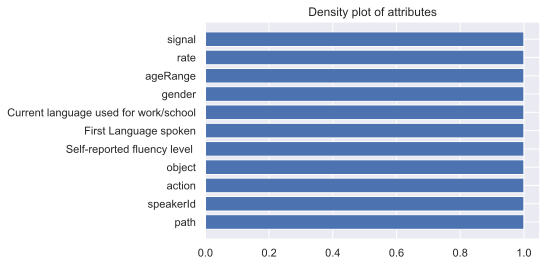

In [3]:
# compute density of each feature and sort them in non increasing order
density = (development.count() / development.shape[0]).sort_values(ascending = False)
# horizontal bar plot
plt.barh(y = density.index, width = density)
plt.title('Density plot of attributes')

Fortunately for us, no missing value is present and we do not require any imputation strategy. Let us now investigate the distributions of these attributes in the development set.

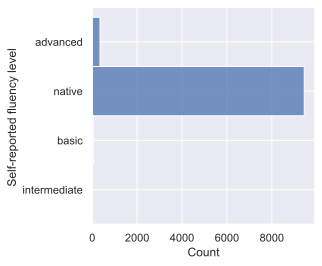

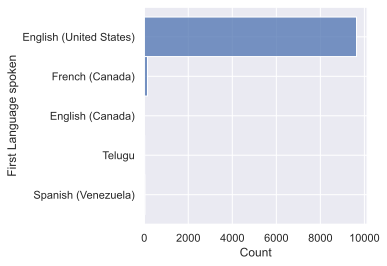

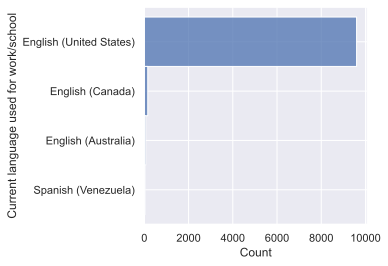

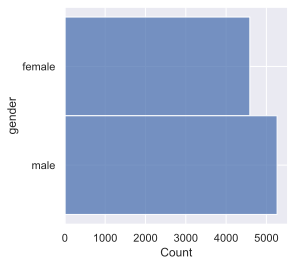

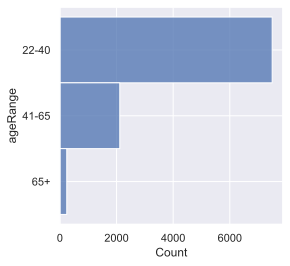

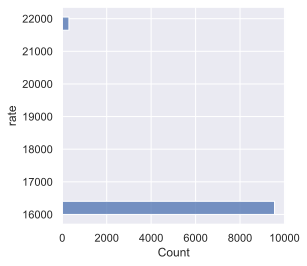

In [4]:
columns = [ col for col in development.columns if col not in [ 'path', 'speakerId', 'action', 'object', 'signal' ] ]

for col in columns:
    fig, ax = plt.subplots(1, 1)
    sns.histplot(development, y = col, ax = ax)
    fig.set_size_inches(4, 4)
    plt.show()

We can observe that there are different current language spoken, where English appears to be the most widely spoken, followed by French. Furthermore, we can count up to 87 different speakers, which means that on average each speaker is associated to 110 recordings, while native speakers are the vast majority. Concerning gender, there is an almost uniform distribution as expected, while age range distribution is more sparse as speakers are older, which means most of the speakers are young people. However, exploration of evaluation set is very relevant to us at the same time. This will give us an idea of how our classification problem is constrained with respect to the dataset attributes.

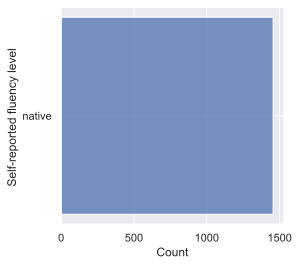

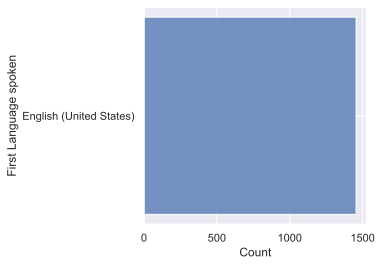

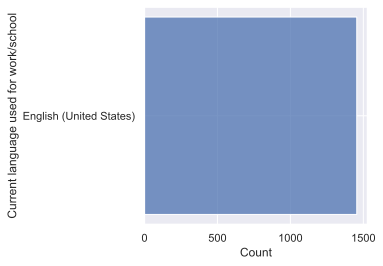

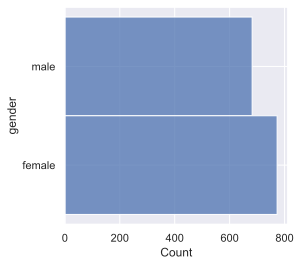

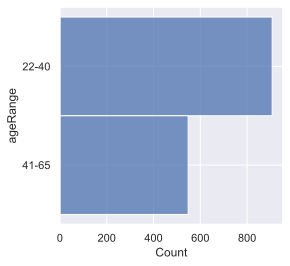

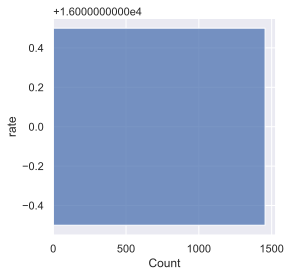

In [5]:
columns = [ col for col in evaluation.columns if col not in [ 'path', 'speakerId', 'action', 'object', 'signal' ] ]

for col in columns:
    fig, ax = plt.subplots(1, 1)
    sns.histplot(evaluation, y = col, ax = ax)
    fig.set_size_inches(4, 4)
    plt.show()
    fig.savefig(f"./images/evaluation_{col.lower().replace(' ', '_').replace('/', '_')}.svg", format = 'svg')

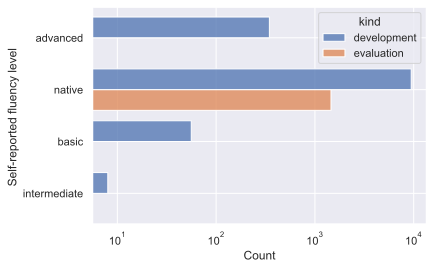

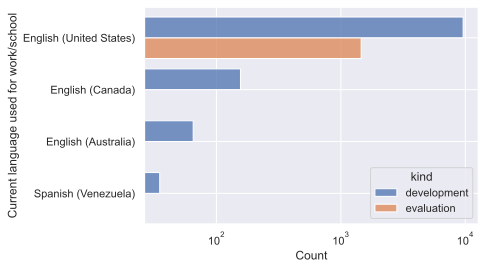

In [5]:
evaluation_copy = evaluation.copy()
development_copy = development.copy()

development_copy['kind'] = 'development'
evaluation_copy['kind'] = 'evaluation'

stacked = pd.concat([ development_copy, evaluation_copy ], axis = 0).reset_index(drop = True)
# direct comparison of discriminant attributes across development and evaluation set
discriminat_attributes = [ 'Self-reported fluency level ', 'Current language used for work/school' ]

for col in discriminat_attributes:
    fig, ax = plt.subplots(1, 1)
    sns.histplot(stacked, y = col, hue = 'kind', multiple = 'dodge', shrink = .8, ax = ax)
    ax.set_xscale('log')
    fig.savefig(f"./images/comparison_{col.lower().replace(' ', '_').replace('/', '_')}.svg", format = 'svg')

Surprisingly enough, the evaluation set is composed only of native English speakers, which is a very strict constraint on our problem. Anyway, this could be an advantage to us, since native speakers will not suffer any foreign accent in speaking English. From this consideration, we take our first decision, which is to train whatever model we are going to construct only on English speakers, thus removing all foreign language speakers from development set. Potentially, in case there would be multiple languages in the evaluation set, we may think of a strategy which trains multiple classifiers, each one corresponding to a different language. In our case, we discarded such approach since English is the unique language appearing in the evaluation set.

In [4]:
# cleaning, keep only english speakers
development = development[development['First Language spoken'].str.startswith('English') & development['Current language used for work/school'].str.startswith('English')]

By removing foreign speaker, we lose any discriminant information about the language spoken, which is uniquely English. Therefore we also decide that any attribute about language will be discarded since it is irrelevant in our approach. Using the same consideration, we also ignore the speaker level information, which is unique in the evaluation set and therefore constant. Anyhow, we also decide to keep all kinds of speakers from training set since they may capture different accents within the English language. Let us move to a valuable consideration on the speakers from evaluation set.

In [8]:
print(f"Number of common speakers is {len(set(development['speakerId'].unique()).intersection(evaluation['speakerId'].unique()))}")

Number of common speakers is 0


Evidently, none of the speakers from evaluation set is also part of the development set, which leads us to indeed discard the `speakerId` information, which cannot relate any information between training set and evaluation set. Only `gender` and `ageRange` remain, which could be easily encoded by means of one hot encoding. Yet, we think that spectral information extracted from each voice recording may encode the difference between voices belonging to both genders and different age ranges. Thus, we also eliminate `gender` and `ageRange` attributes. Indeed, by training any model using such attributes we had proved how scores get worse when they are included.

### Audio recordings exploration <a name="pare"></a>

This approach leaves us only the audio recording, which, in fact, will be the effective object of feature extraction. We exhaustively motivated why we genuinely believe that audio recording may encode all meaningful information regarding our problem. Audio recordings are encoded using wav format, that is they are stored as sequences of 16 bits integers holding amplitudes in time domain.

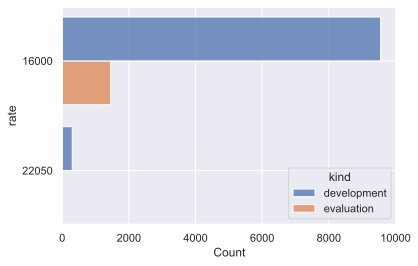

In [6]:
# sample rate of recordings belonging to development and evaluation set set
development_copy = development.copy()
development_copy['kind'] = 'development'
evaluation_copy = evaluation.copy()
evaluation_copy['kind'] = 'evaluation'
stacked = pd.concat([ development_copy, evaluation_copy ], axis = 0).reset_index(drop = True)
stacked['rate'] = stacked['rate'].astype(str)
fig, ax = plt.subplots(1, 1)
sns.histplot(stacked, y = 'rate', hue = 'kind', multiple = 'dodge', shrink = 0.8, ax = ax)
fig.savefig(f"./images/sample_rate_comparison.svg", format = 'svg')

Evidently, some minority of recordings belonging to the development set share a higher sample rate of 22050 Hz, which thereby has to be adjusted in order to have uniform recordings. The strategy which is going to be employed is a down resampling of such recordings to the mostly spread sample rate of 16000 Hz.

Let us explore the distribution of lengths among all recordings in development set. 

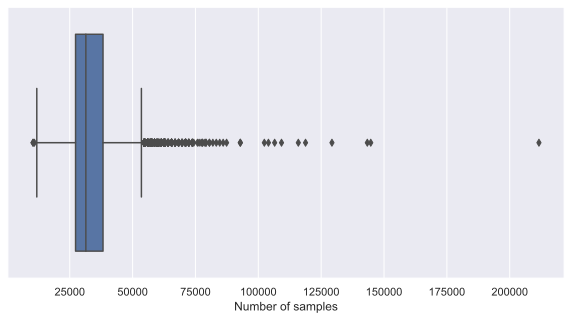

{
  "0-percentile length": 10403,
  "5-percentile length": 21845,
  "25-percentile length": 27307,
  "50-percentile length": 31403,
  "75-percentile length": 38229,
  "95-percentile length": 50517,
  "100-percentile length": 211627
}


In [10]:
lengths = [ audio[1].shape[0] for audio in audios.values if audio[0] == 16000 ]
lengths.sort()
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
sns.boxplot(x = lengths, ax = ax)
# plt.title('Box plot of audio recordings lengths')
plt.xlabel('Number of samples')
plt.show()
print(json.dumps({ f'{p}-percentile length': int(np.percentile(lengths, p)) for p in [ 0, 5, 25, 50, 75, 95, 100 ] }, indent = '  '))
fig.savefig('./images/length_percentiles.svg', format = 'svg')

Apparently the lengths of audios are quite different and they range from roughly 10k samples to 211k samples, though the distribution of lengths is quite skewed towards shorter lengths which suggests that excessive lengths may be outliers. This could be a clue suggesting the presence of long leading and trailing silence in some longer recordings. However, the 95% of audios' lengths fall within about 57k samples.

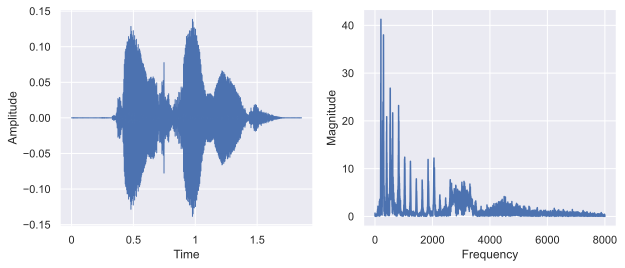

In [11]:
# random sample of audio recordings to plot
sample_audios_indexes = [ 0 ]
# sample rate
sr = 16000

for i in sample_audios_indexes:
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)
    signal = development.loc[i, 'signal'] / 32768
    # amplitudes must be normalized in range [-1, 1] according to librosa expected input 
    librosa.display.waveshow(signal, sr = sr, ax = axs[0])
    # fourier transform
    n = len(signal)
    yf = fft.fft(signal)[:n // 2]
    xf = fft.fftfreq(len(signal), 1 / sr)[:n // 2]
    sns.lineplot(x = xf, y = np.abs(yf), ax = axs[1])
    axs[0].set_ylabel('Amplitude')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Magnitude')
    # fig.suptitle(f"Audio recording {development.loc[i, 'path'].split('/')[-1]}")
    plt.show()
    fig.savefig(f"./images/audio_{development.loc[i, 'path'].split('/')[-1].removesuffix('.wav')}.svg", format = 'svg')

As a confirmation to our theory, we can spot the presence of silence in audios, which will be dealt with in the preprocessing pahse of our pipeline.

### Target inspection <a name="pti"></a>

Now we need to inspect how the target labels `action` and `object` are distributed.

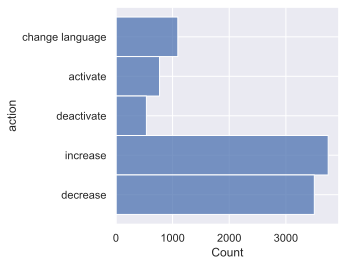

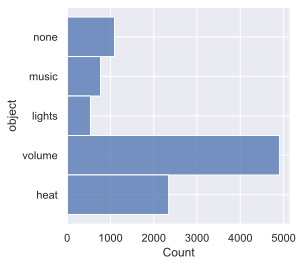

In [12]:
targets = [ 'action', 'object' ]

for col in targets:
    fig, ax = plt.subplots(1, 1)
    sns.histplot(development, y = col, ax = ax)
    fig.set_size_inches(4, 4)
    plt.show()

As it can be seen distributions of different categories within both targets are quite far from being uniform. Anyhow, it is also interesting to inquire which are the combinations of `action` and `object` that realistically occur in the development set.

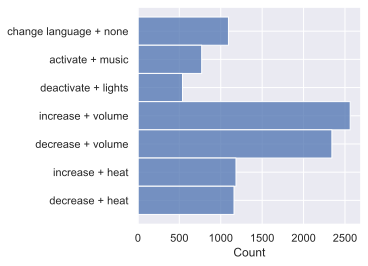

In [13]:
# intent is the combination of attribute action and object
intent = development['action'].astype(str) + ' + ' + development['object'].astype(str)
fig, ax = plt.subplots(1, 1)
sns.histplot(y = intent, ax = ax)
# ax.set_title('Intent distribution')
fig.set_size_inches(4, 4)
plt.show()
fig.savefig('./images/intent_distribution.svg', format = 'svg')

Since we think that some combinations of `action` and `object` may be semantically meaningless, for example `change language` + `volume`, we decide to combine from the very beginning both targets into a single target which directly encodes the intent. The encoding follows the same rule that is expected in the evaluation. Therefore, we are going to construct the overall target by means of a string concatenation, namely the intent. We end up with 7 different classes, which constitutes our final target for the classification problem.

## Preprocessing <a name="p3"></a>

As we already stated, the audio files we are provided are encoded in wave format, that is a sequence of 16 bits integers. Specifically, all the recordings have been sampled at frequency 16000 Hz. Before proceding, each audio recording is normalized in range [-1, 1] using 32768, which is the maximum feasible (absolute) value for any amplitude. The first step consists in cleaning each recording from irrelevant silence. This is achieved by cutting off those amplitudes which are below a certain threshold. Such threshold has been set to 20 dB in our case, and the choice has been made in order to preserve the overall resemblance of the trimmed audio with respect to the original one. Then, we have to uniform the amount of samples across all the recordings, that is the length. To us, the simplest way to achieve this consisted in computing the index of the last non zero amplitude across all recordings, in order to exclude the trailing silence. Hence we compute the 95% percentile of these lengths. This value will be the final number of samples chosen for each recording. Those recordings which are longer in time are cut (because of our choice they are 5% of all), while shorter recordings are filled with trailing zeros. Finally this result in a value which is roughly 30000 samples, corresponding to a duration of 1.9 seconds since the sampling frequency is 16000 Hz.

In [5]:
class AudioPreProcessor(TransformerMixin):
    def __init__(self, sr: int = 16000) -> None:
        self.sr = sr

    def fit(self, X, y = None, **params):
        X_resampled = X.copy()
        # first resample to target frequency 16000
        X_resampled['signal'] = [ librosa.resample(signal / 32768, orig_sr = rate, target_sr = self.sr, res_type = 'soxr_qq') if rate != self.sr else (signal / 32768) for rate, signal in zip(X_resampled['rate'], X_resampled['signal']) ]
        # expect X to be full dataset with signal column holding wave signal arrays
        # learn fixed count of samples from trimmed wave signals
        trimmed = [ librosa.effects.trim(audio, top_db = 20)[0] for audio in X_resampled['signal'].values ]
        # take 95% percentile to compute the chosen length for all recordings
        self.samples = int(np.percentile([ audio.shape[0] - np.argmin((audio == 0)[::-1]) for audio in trimmed ], 95))

        return self

    def transform(self, X, y = None, **params):
        X_resampled = X.copy()
        # first resample to target frequency 16000
        X_resampled['signal'] = [ librosa.resample(signal / 32768, orig_sr = rate, target_sr = self.sr, res_type = 'soxr_qq') if rate != self.sr else (signal / 32768) for rate, signal in zip(X_resampled['rate'], X_resampled['signal']) ]
        # trim and pad wave files
        trimmed = [ librosa.effects.trim(audio, top_db = 20)[0] for audio in X_resampled['signal'].values ]
        waves = np.stack([ audio[:self.samples] if audio.shape[0] >= self.samples else np.pad(audio, (0, self.samples - audio.shape[0]), constant_values = (0, 0)) for audio in trimmed ], axis = 0)    
        # result is wave signals with corresponding indexes
        return pd.DataFrame(waves, index = X.index)

The resampling, regarding those recordings with sample rate different from 16000 Hz, is performed using a cubic interpolation, which results in very fast computation.

In [6]:
# random sample of audio recordings to plot
sample_audios_indexes = [ 0 ]
# sample rate
sr = 16000
# preprocessor on sample
preprocessed_signals = AudioPreProcessor().fit_transform(development.iloc[sample_audios_indexes, :]).values

for i, signal in zip(sample_audios_indexes, preprocessed_signals):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)
    # amplitudes must be normalized in range [-1, 1] according to librosa expected input 
    librosa.display.waveshow(signal, sr = sr, ax = axs[0])
    # fourier transform
    n = len(signal)
    yf = fft.fft(signal)[:n // 2]
    xf = fft.fftfreq(len(signal), 1 / sr)[:n // 2]
    sns.lineplot(x = xf, y = np.abs(yf), ax = axs[1])
    axs[0].set_ylabel('Amplitude')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Magnitude')
    plt.show()
    fig.savefig(f"./images/preprocessed_audio_{development.loc[i, 'path'].split('/')[-1].removesuffix('.wav')}.svg", format = 'svg')

## Feature extraction <a name="p4"></a>

Feature extraction is the most delicate and important step in the construction of our pipeline. We known from the beginning that the choice of features is what really matters and defines the accuracy of any model we may build. Thereby, we are going to extract three macro groups of features from audio recordings. Each group is evidently capable of encoding relevant information when modelling each recording wave signal.

### Statistical features <a name="psf"></a>

Statical features are information computed in time domain. Particularly, we divide each recording $x(t)$ in time windows of the same length. Each time window will have a duration of 50 milliseconds, whose value was chosen after some attempts. So, each window will contain exactly $W = 800$ samples and each recording, due to a length of about 30000 samples, will be partitioned into less that 40 windows. Now, for each $n$-th window, we compute some statistical information.

| Feature            | Value                                                                           | Granularity |
|--------------------|---------------------------------------------------------------------------------|-------------|
| Mean               | $\frac{1}{W}\sum_i x(i)$                                                        | window      |
| Standard deviation | $\sqrt{\frac{1}{W}\sum_i (x(i) - \bar{x})}$                                     | window      |
| Skewness           | $W\dfrac{\sum_i (x(i) - \bar{x})^4}{[\sum_i (x(i) - \bar{x})^2]^2}$             | overall     |
| Kurtosis           | $W\dfrac{\sum_i (x(i) - \bar{x})^3}{[\sum_i (x(i) - \bar{x})^2]^{\frac{3}{2}}}$ | overall     |

Note that each of these mean and standard deviation statistics are strictly computed on each window, while skewness and kurtosis are overall information for each recording.

### Time domain features <a name="ptf"></a>

Time domain features are another set of meaningful features related to the shape of each recording in the time domain. They directly followed statistical features in this sense. Again, they are computed with respect to each time window.

| Feature            | Value                                                                     | Granularity |
|--------------------|---------------------------------------------------------------------------|-------------|
| Zero crossing rate | $\dfrac{1}{W}\sum_i \|\mathrm{sign}(x(i + 1)) - \mathrm{sign}(x(i))\|$    | window      |
| Root mean square   | $\sqrt{\dfrac{1}{W} \sum_i x(i)^2}$                                       | window      |
| Peak-peak distance | $\max(x(\cdot)) - \min(x(\cdot))$                                         | window      |
| Peak               | $\max(\|x(\cdot)\|)$                                                      | window      |
| Crest factor       | $\dfrac{\max(\|x(\cdot)\|)}{\sqrt{\dfrac{1}{W} \sum_i x(i)^2}}$           | window      |
| Shape factor       | $\dfrac{\sqrt{\dfrac{1}{W} \sum_i x(i)^2}}{\dfrac{1}{W} \sum_i \|x(i)\| }$| window      |
| Impulse factor     | $\dfrac{\max(\|x(\cdot)\|)}{\dfrac{1}{W} \sum_i \|x(i)\| }$               | window      |
| Margin factor      | $\dfrac{\max(\|x(\cdot)\|)}{\dfrac{1}{W} \sum_i \sqrt{\|x(i)\|}}$         | window      |

The zero crossing rate is related to how many times the signal changes its sign within each time window. The root mean square is also well known as the energy of a signal in signal analysis.

### Frequency domain features <a name="pff"></a>

Now we concern about the spectral domain. Each wave signal can be transformed from the time domain into the frequency domain. The transformation is performed through the discrete Fourier transform (DFT), which delivers a spectrum of magnitudes associated to each frequency. In particular, we extract only the part with real frequencies. 

$$
\begin{align*}
X(k) = \mathcal{F}\{x(t)\} = \sum\limits_{t = 0}^T x(t) \exp\Big(-i \dfrac{2 \pi}{T} k t\Big)
\end{align*}
$$

On the spectrum of frequencies the main features are considered and extracted. Like for other features, we consider several time windows.

| Feature            | Value                                                                      | Granularity |
|--------------------|----------------------------------------------------------------------------|-------------|
| MFCC               | Mel-frequency cepstral coefficients                                        | window      |
| Mel spectrogram    | Spectrogram with frequencies in Mel scale                                  | window      |
| Spectral centroid  | Weighted mean of frequencies using magnitudes                              | window      |
| Spectral rolloff   | Frequency below which 85% of spectrum magnitudes are located               | window      |
| Spectral bandwidth | Variance with respect to the spectral centroid                             | window      |
| Spectral flatness  | Quantifies how much noisy the wave signal is (1.0 is close to white noise) | window      |
| Spectral kurtosis  | Tailedness of the distribution of frequency spectrum                       | window      |
| Spectral skewness  | Asymmetry of the distribution of frequency spectrum                        | window      |
| Spectral flux      | Measures how quickly power spectrum changes across a signal                | window      |
| Spectral contrast  | Difference between spectral energy peak and minimum                        | window      |
| Spectral entropy   | Uncertainty of power spectrum according to Shannon entropy                 | window      |

Mel-frequency cepstral coefficients are very popular when doing audio analysis and classification. Such coefficients are extracted from a complex computation which involves Fourier transform and discrete cosine transform on logarithmic power spectrum in Mel frequency. Mel scale is a logarithmic scale which is very close to the human perception of frequencies.

$$
\begin{align*}
[f]_{\textrm{mel}} = 
\begin{cases}
f &\quad \textrm{if} \quad f \leq 1000 \text{ Hz} \\
1127 \cdot \ln(1 + f / 700) &\quad \textrm{if} \quad f > 1000 \text{ Hz}
\end{cases}
\end{align*}
$$

Since Mel scale is human-like, the usage of Mel-frequency cepstral coefficients is a powerful tools when doing audio recognition. All other features are extracted from the spectrum of magnitude of frequencies or from the power spectrum. They encode information about the shape of frequency distributions within each time window. Hence, they may be very good predictors for our task.

Let us implement a feature extraction transform as part of the pipeline.

In [18]:
class FeatureExtractor(TransformerMixin):
    def __init__(self, sr: int = 16000, period: float = 0.05) -> None:
        self.sr = sr
        self.period = period
        self.window_samples = int(sr * self.period)

    def fit(self, X, y, **params):
        return self

    def transform(self, X, y = None, **params):
        # machine precision for avoiding zero division error
        eps = 1e-14
        # wave signals
        waves = X.values if type(X) is pd.DataFrame else X
        # compute sliding windows
        nwindows = int(np.ceil(waves.shape[1] / self.window_samples))
        windows = np.array_split(waves, nwindows, axis = 1)
        # statistical features
        skewness = stats.skew(waves, axis = 1).reshape(-1, 1)
        kurtosis = stats.kurtosis(waves, axis = 1).reshape(-1, 1)
        mean = [ None for i in range(len(windows)) ]
        std = [ None for i in range(len(windows)) ]
        # time domain features
        zcrossings = [ None for i in range(len(windows)) ]
        rms = np.array([ librosa.feature.rms(y = wave, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        zcrate = np.array([ librosa.feature.zero_crossing_rate(y = wave, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        peak_peak = [ None for i in range(len(windows)) ]
        peak = [ None for i in range(len(windows)) ]
        crest_factor = [ None for i in range(len(windows)) ]
        shape_factor = [ None for i in range(len(windows)) ]
        margin_factor = [ None for i in range(len(windows)) ]
        impulse_factor = [ None for i in range(len(windows)) ]
        # frequency domain features
        spectrum = np.abs(fft.rfft(waves, axis = 1, workers = -1))
        freqs = fft.rfftfreq(waves.shape[1], d = 1.0 / self.sr)
        mfcc = np.array([ librosa.feature.mfcc(y = wave, sr = self.sr, n_mfcc = 20) for wave in waves ]).reshape(waves.shape[0], -1)
        melspectrogram = np.array([ librosa.feature.melspectrogram(y = wave, sr = self.sr, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        centroids = np.array([ librosa.feature.spectral_centroid(y = wave, sr = self.sr, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        rolloff = np.array([ librosa.feature.spectral_rolloff(y = wave, sr = self.sr, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        bandwidth = np.array([ librosa.feature.spectral_bandwidth(y = wave, sr = self.sr, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        flatness = np.array([ librosa.feature.spectral_flatness(y = wave, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        spectral_kurtosis = (np.mean(spectrum ** 4, axis = 1) / (np.mean(spectrum ** 2, axis = 1) ** 2) - 2).reshape(-1, 1)
        spectral_skewness = (np.mean(spectrum ** 3, axis = 1) / (np.std(spectrum, axis = 1) ** 3)).reshape(-1, 1)
        spectral_flux = np.array([ librosa.onset.onset_strength(y = wave, sr = self.sr, hop_length = self.window_samples) for wave in waves ])
        spectral_contrast = np.array([ librosa.feature.spectral_contrast(y = wave, hop_length = self.window_samples) for wave in waves ]).mean(axis = 1)
        spectral_entropy = [ None for i in range(len(windows)) ]

        # construct time domain features from each frame
        for i in range(len(windows)):
            zcrossings[i] = np.sum(librosa.zero_crossings(windows[i], axis = 1), axis = 1)
            mean[i] = np.mean(windows[i], axis = 1)
            std[i] = np.std(windows[i], axis = 1)
            peak[i] = np.max(np.abs(windows[i]), axis = 1)
            peak_peak[i] = np.max(windows[i], axis = 1) - np.min(windows[i], axis = 1)
            crest_factor[i] = peak[i] / (eps + rms[:, i])
            shape_factor[i] = rms[:, i] / (eps + np.mean(np.abs(windows[i]), axis = 1))
            margin_factor[i] = peak[i] / (eps + np.mean(np.sqrt(np.abs(windows[i])), axis = 1) ** 2)
            impulse_factor[i] = peak[i] / (eps + np.mean(np.abs(windows[i]), axis = 1))
            spectral_entropy[i] = ant.spectral_entropy(windows[i], self.sr, method = 'fft', normalize = True, axis = 1)

        # concat features horizontally
        zcrossings = np.vstack(zcrossings).T
        mean = np.vstack(mean).T
        std = np.vstack(std).T
        peak = np.vstack(peak).T
        peak_peak = np.vstack(peak_peak).T
        crest_factor = np.vstack(crest_factor).T
        shape_factor = np.vstack(shape_factor).T
        margin_factor = np.vstack(margin_factor).T
        impulse_factor = np.vstack(impulse_factor).T
        spectral_entropy = np.array(spectral_entropy).T

        features = np.concatenate([ margin_factor, impulse_factor, crest_factor, shape_factor, peak, peak_peak, zcrossings, skewness, kurtosis, mean, std, spectral_entropy, mfcc, rms, melspectrogram, centroids, rolloff, bandwidth, flatness, zcrate, spectral_kurtosis, spectral_skewness, spectral_flux, spectral_contrast ], axis = 1)

        return features

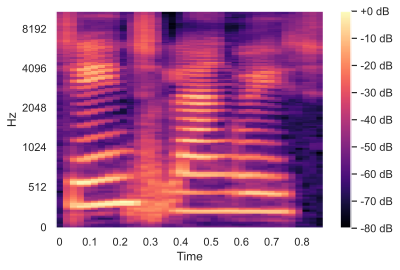

In [17]:
from matplotlib.ticker import FormatStrFormatter

# random sample of audio recordings to plot
sample_audios_indexes = [ 0 ]
# sample rate
sr = 16000
# preprocessor on sample
preprocessed_signals = AudioPreProcessor().fit_transform(development.iloc[sample_audios_indexes, :]).values
# print Mel spectrogram for sample signals
for i, signal in zip(sample_audios_indexes, preprocessed_signals):
    fig, ax = plt.subplots(1, 1)
    M = librosa.feature.melspectrogram(y = signal, sr = 16000)
    M_db = librosa.power_to_db(M, ref = np.max)
    image = librosa.display.specshow(M_db, y_axis = 'mel', x_axis = 'time', ax = ax)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    fig.colorbar(image, ax = ax, format = "%+2.f dB")
    fig.savefig(f"./images/preprocessed_audio_mel_spectrogram_{development.loc[i, 'path'].split('/')[-1].removesuffix('.wav')}.svg", format = 'svg')

## Classification <a name="p5"></a>

Given the preprocessing pipeline we described before, let us now approach the classification problem using different well known models.

### Feature selection <a name="pfs"></a>

Before proceding, since data is quite large, we decide to apply a feature selection approach which is not very complex. Indeed we are going to exclude those features whose overall variance is below a fixed threshold. In this way we get rid of those features which may not have an important impact in predicting the target variable. Specifically, we use a variance threshold of `0.01` which is relatively low. Such a choice has been carried out in order to limit the amount of features excluded from classification.

### Implementation of feed forward neural network <a name="pifnn"></a>

Leaded by the thought of not missing any opportunity in making more accurate predictions, we decided to implement a feedforward neural network by stacking different layers. The choice related to the number of layers, neurons and epochs has been made very practically by making different attempts in assessing the performance over the development set. Anyway, such investigation has been avoided here. Instead we explicitly enabled the multi processing computation in order to speed up the classification.

In [8]:
from sklearn.base import ClassifierMixin

class FeedForwardNeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, activation: str = 'relu', optimizer: str = 'adam', epochs: int = 150):
        # activation function
        self.activation = activation
        # optimizer
        self.optimizer = optimizer
        # epochs for optimization
        self.epochs = epochs
        # label encoder since it does not accept string labels differently from sklearn models
        self.label_encoder = LabelEncoder()

    def fit(self, X, y, **params):
        # fit label encoder
        y_encoded = self.label_encoder.fit_transform(y)
        # number of classes (unique labels) employed in output layer
        self.nclasses = len(self.label_encoder.classes_)
        # construct a multilayer feed forward neural network
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(1024, activation = self.activation, input_shape = (X.shape[1],)))
        self.model.add(keras.layers.Dense(512, activation = self.activation))
        self.model.add(keras.layers.Dense(256, activation = self.activation))
        self.model.add(keras.layers.Dense(128, activation = self.activation))
        self.model.add(keras.layers.Dense(64, activation = self.activation))
        self.model.add(keras.layers.Dense(self.nclasses, activation = 'softmax'))
        self.model.compile(optimizer = self.optimizer, loss = 'sparse_categorical_crossentropy', metrics = [ 'accuracy' ], jit_compile = True)
        # fit the data, possibily enabling multiprocessing computations (verbose = 0 is silent, while = 3 is fully descriptive)
        self.model.fit(X, y_encoded, epochs = self.epochs, batch_size = 128, use_multiprocessing = True, verbose = 0)

        return self

    def predict(self, X, y = None, **params):
        return self.label_encoder.inverse_transform(np.argmax(self.model.predict(X, verbose = 0), axis = 1))


The implementation using Keras library suffers from the lack of setting a random state for creating reproducible results. So, as it can be seen, scores obtained using the neural network will often be similar tough not the same.

### Performance evaluation <a name="ppe"></a>

Classification is approached by trying different models, including the neural network implemented before. The classification is carried out on a representative sample of 1000 elements, in order to avoid using the whole dataset, which would result in huge computational times. The training set is 80% of the original sample, therefore consisting in 800 records. Furtheremore, audio signals are preprocessed according to the pipeline we constructed. Finally, a standardization step is prefixed to those models which otherwise would suffer the absence of a common scale within the data, namely the logistic regression, support vector machine, nearest neighbours and neural network.

In [19]:
# min variance threshold for feature selection
minvariance = 0.01
# pipeline of preprocessing
preprocessor = Pipeline([ ('audio', AudioPreProcessor()), ('extraction', FeatureExtractor()), ('selection', VarianceThreshold(minvariance)) ])
# all classifiers, with the exception of the random forest and the gradient boosting classifier, expect the features to be properly scaled
candidates = {
    'LogisticRegression': Pipeline([ ('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter = 100000, n_jobs = -1, random_state = 0)) ]),
    'LogisticRegression': Pipeline([ ('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter = 100000, n_jobs = -1, random_state = 0)) ]),
    'RandomForestClassifier': Pipeline([ ('classifier', RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators = 100, criterion = 'gini')) ]), 
    'HistGradientBoostingClassifier': Pipeline([ ('classifier', HistGradientBoostingClassifier(loss = 'log_loss', random_state = 0)) ]), 
    'SVC': Pipeline([ ('scaler', StandardScaler()), ('classifier', SVC(C = 1, random_state = 0)) ]),
    'KNeighborsClassifier': Pipeline([ ('scaler', StandardScaler()), ('classifier', KNeighborsClassifier(n_jobs = -1)) ]),
    'FeedForwardNeuralNetworkClassifier': Pipeline([ ('scaler', StandardScaler()), ('classifier', FeedForwardNeuralNetworkClassifier(activation = 'relu')) ]),
}
# testing candidates
sample_size = 1000
sample = development.sample(sample_size, replace = False, random_state = 0) if sample_size < development.shape[0] else development
X, y = sample, (sample['action'].astype(str) + sample['object'].astype(str))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)
print('Preprocessing...')
X_train = preprocessor.fit_transform(X_train, y_train)
X_test = preprocessor.transform(X_test)
print(f'Feature extracted {X_train.shape[1]}')
# base performance evaluation (without cross validation) of candidate models
for name, candidate in candidates.items():
    print(f'[{name}] Training...')
    # compose model through intrinsic label encoding
    candidate.fit(X_train, y_train)
    # compute score on test set
    score = accuracy_score(y_test, candidate.predict(X_test))
    print(f'[{name}] Base test score: {score:.3f}')


Preprocessing...


/usr/local/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


(800, 14861)
(14861,)
(800, 25)


/usr/local/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


(200, 14861)
(14861,)
(200, 25)
Feature extracted 1783
[LogisticRegression] Training...
[LogisticRegression] Base test score: 0.470
[RandomForestClassifier] Training...
[RandomForestClassifier] Base test score: 0.425
[HistGradientBoostingClassifier] Training...
[HistGradientBoostingClassifier] Base test score: 0.495
[SVC] Training...
[SVC] Base test score: 0.445
[KNeighborsClassifier] Training...
[KNeighborsClassifier] Base test score: 0.410
[FeedForwardNeuralNetworkClassifier] Training...


2023-01-22 15:08:47.415457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 15:08:49.923301: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f82b61aa9b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-22 15:08:49.923695: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-01-22 15:08:49.926095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler f

[FeedForwardNeuralNetworkClassifier] Base test score: 0.505


Not very surpringly, ensemble models performed better than remaing ones. However, all scores are similarly aligned.

| model | sample score |
|---|---|
| `LogisticRegression` | `0.465` |
| `RandomForestClassifier` | `0.460` |
| `HistGradientBoostingClassifier` | `0.520` |
| `SVC` | `0.455` |
| `KNeighborsClassifier` | `0.425` |
| `FeedForwardNeuralNetworkClassifier` | `0.500` (with some randomness) |

## Optimization <a name="p6"></a>

We decided to investigate and improve the performance of three models which seem to be promising, namely `RandomForestClassifier`, `HistGradientBoostingClassifier` and `FeedForwardNeuralNetworkClassifier`. Since the dataset is relatively large and feature extraction is heavily expensive in terms of computational time, we decided to select a subset of 1000 elements from the original development set. We also perform feature extraction a priori and not a part of the classifier pipeline, in order to speed up the process. Note that optimization is performed by selecting the best scoring model on average. This means that the score of a certain configured model is averaged over a 5-fold partition.

In [59]:
# sample for testing performance
sample_size = 1000
sample = development.sample(sample_size, replace = False, random_state = 0) if sample_size < development.shape[0] else development
y = sample['action'].astype(str) + sample['object'].astype(str)
# min variance threshold for feature selection
minvariance = 0.01
# pipeline of preprocessing
preprocessor = Pipeline([ ('audio', AudioPreProcessor()), ('extraction', FeatureExtractor()), ('selection', VarianceThreshold(minvariance)) ])
# extract all development features
print('Preprocessing')
X = preprocessor.fit_transform(sample, y)
print(f'Features shape is {X.shape}')

Preprocessing


/usr/local/lib/python3.9/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


Features shape is (1000, 1757)


The following search grid is explored during optimization of the chosen models.

| model | grid | value |
|---|---|---|
| `RandomForestClassifier` | random_state<br>n_estimators<br>criterion | [`0`]<br>[`100`, `250`, `500`, `750`]<br>[`gini`, `entropy`, `log_loss`] |
| `HistGradientBoostingClassifier` | random_state<br>learning_rate<br>loss<br>max_iter | [`0`]<br>[`0.075`, `0.1`, `0.125`]<br>[`log_loss`]<br>[`100`, `125`, `150`] |
| `FeedForwardNeuralNetworkClassifier` | activation<br>optimizer<br>loss<br>layers<br>epochs<br>batch_size | [`relu`, `tanh`, `sigmoid`]<br>[`adam`, `sgd`, `adadelta`]<br>[`sparse_categorical_crossentropy`]<br>[(`1024`, `512`, `256`, `128`, `64`, `7`)]<br>[`100`, `150`, `200`]<br>[`128`] |

### Random forest classifier <a name="prfc"></a>

The random forest model is a powerful ensemble model which trains independently several decision trees on a random sample of features per each one. This technique has the main advantage of being robust to overfitting. In our tuning we focus on the quantity of trees and the split criterion chosen at each node.

In [60]:
search = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = { 'n_estimators': [ 100, 250, 500, 750 ], 'criterion': [ 'gini', 'entropy', 'log_loss' ], 'random_state': [ 0 ], 'n_jobs': [ -1 ] },
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1
)
search.fit(X, y)
print('[RandomForestClassifier] best-score: {:.3f}, best-params: {}'.format(search.best_score_, search.best_params_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[RandomForestClassifier] best-score: 0.510, best-params: {'criterion': 'entropy', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 0}


### Gradient boosting classifier <a name="pgbc"></a>

In order to capture some relationships within the data in more depth, we decide to optimize the gradient boosting model. Like the random forest, it makes use of several trees. However the training process is completely different. Whilst the random forest independetly fit each decision tree, possibily in parallel, instead the gradient boosting model trains each decision tree sequentially, thus it is not capable of parallelizing. Anyhow, its training benefits from a corrective process in which each new tree is trained on the residual error. Therefore this tree is constructed in order to correct the prediction error of previous trees with respect to the target. The residual error and correction step are applied by means of gradient computation and descent. The learning rate and number of epochs is investigated during optimization in this case.

In [22]:
search = GridSearchCV(
    estimator = HistGradientBoostingClassifier(),
    param_grid = { 'loss': [ 'log_loss' ], 'learning_rate': [ 0.075, 0.1, 0.25 ], 'max_iter': [ 100, 125, 150 ], 'random_state': [ 0 ] },
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1
)
search.fit(X, y)
print('[HistGradientBoostingClassifier] best-score: {:.3f}, best-params: {}'.format(search.best_score_, search.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[HistGradientBoostingClassifier] best-score: 0.472, best-params: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_iter': 125, 'random_state': 0}


### Feedforward neural network <a name="pfnn"></a>

The last model which we decide to optimize is the feedforward neural network, according to the architecture chosen for the implementation. A neural network has a very high capability of learning the non linear and peculiar relationships from the data and the target. Such training is performed again through a variant of stochastic gradient descent. In practice the network is trained in order to minimize the prediction errors and the neurons' coefficients are updated accordingly by means of gradient computation and descent. In this case we decide to try different activation functions involved in computing each neuron's output. Besides, differently from tree based models, here we need to scale the data since linear combination of features are effectively calculated before feeding activation functions.

In [ ]:
search = GridSearchCV(
    estimator = Pipeline([ ('scaler', StandardScaler()), ('classifier', FeedForwardNeuralNetworkClassifier()) ]),
    param_grid = { 'classifier__activation': [ 'relu', 'tanh', 'sigmoid' ], 'classifier__optimizer': [ 'adam', 'sgd', 'adadelta' ], 'classifier__epochs': [ 100, 150, 200 ] },
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1
)
search.fit(X, y)
print('[FeedForwardNeuralNetworkClassifier] best-score: {:.3f}, best-params: {}'.format(search.best_score_, search.best_params_))

## Results <a name="p7"></a>

Once we found out which are the optimized configurations for our models, let us compute the average score on the entire development set by means of a cross validation strategy. Such strategy partitions the dataset in 5 groups and uses 4 of them to train each model and the remaining one for the validation. Thus, given each tuned model, five scores are computed for each group. The average score delivers us an idea of the overall performance of the optimized model. Besides, we decide to avoid an explicit feature selection here, since we have seen that performance apparently gets worse when variance threshold feature selection is applied. Hence we rely on the ability of such models in avoiding overfitting.

In [11]:
y = development['action'].astype(str) + development['object'].astype(str)
# min variance threshold for feature selection
minvariance = 0.01
# pipeline of preprocessing, without feature selection here
preprocessor = Pipeline([ ('audio', AudioPreProcessor()), ('extraction', FeatureExtractor()) ])
# all tuned classifiers with previous results
tuned = {
    'RandomForestClassifier': Pipeline([ ('classifier', RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators = 750, criterion = 'entropy')) ]), 
    'HistGradientBoostingClassifier': Pipeline([ ('classifier', HistGradientBoostingClassifier(learning_rate = 0.1, loss = 'log_loss', max_iter = 150, random_state = 0)) ]),
    'FeedForwardNeuralNetworkClassifier': Pipeline([ ('scaler', StandardScaler()), ('classifier', FeedForwardNeuralNetworkClassifier(activation = 'relu', optimizer = 'adam', epochs = 200)) ]),
}
# extract all development features
print('Preprocessing... (may take up to 10 minutes)')
X = preprocessor.fit_transform(development, y)
print(f'Features shape is {X.shape}')

# preprocess entire dataset for cross validation using the tuned models
for name, model in tuned.items():
    print(f'[{name}] cross validation... (may take up to 7 minutes)')
    scores = cross_val_score(
        model,
        X,
        y,
        cv = 5,
        scoring = 'accuracy',
        n_jobs = -1,
        verbose = 1
    )
    # emit average score of tuned model after cross validation
    print(f'[{name}] cross validation score: {np.mean(scores):.3f} ± {np.std(scores):.3f}')

Preprocessing... (may take up to 10 minutes)


/usr/local/lib/python3.9/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in true_divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


Features shape is (9650, 1965)


The following results are obtained after cross validation on whole development set.

| **model** | `RandomForestClassifier` | `HistGradientBoostingClassifier` | `FeedForwardNeuralNetworkClassifier` |
|---|---|---|---|
| **configuration** | random_state=`0`<br>n_estimators=`750`<br>criterion=`entropy` | random_state=`0`<br>learning_rate=`0.1`<br>loss=`log_loss`<br>max_iter=`150` | activation=`relu`<br>optimizer=`adam`<br>epochs=`200` |
| **score** | `0.654` ± `0.054` | `0.696` ± `0.049` | `0.760` ± `0.057` |

Evidently, the neural network outperforms the other tuned models, while the gradient boosting seems better than the random forest. Since the neural network uses gradient descent in order to minimize the error function when fitting the data, this could lead to a deeper interpretation of the relationships between features, particularly the non linear ones. The same applies to the gradient boosting classifier, apparently like a random forest, which is trained on the minimization of residuals, namely prediction errors. Infact, the random forest constructs many independent trees and such independency may be the cause of missed relationships in the data, which is solved by the gradient based mechanism behind the gradient boosting model.

Let us try the same cross validation but using a feature selection criteria before, so that we could see how results effectively change when dimensionality reduction is applied.

In [20]:
y = development['action'].astype(str) + development['object'].astype(str)
# pipeline of preprocessing, with feature selection here
preprocessor = Pipeline([ ('audio', AudioPreProcessor()), ('extraction', FeatureExtractor()), ('selection', SelectFromModel(ExtraTreesClassifier(n_estimators = 750, criterion = 'entropy', random_state = 0, n_jobs = -1))) ])
# all tuned classifiers with previous results
tuned = {
    'RandomForestClassifier': Pipeline([ ('classifier', RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators = 750, criterion = 'entropy')) ]), 
    'HistGradientBoostingClassifier': Pipeline([ ('classifier', HistGradientBoostingClassifier(learning_rate = 0.1, loss = 'log_loss', max_iter = 150, random_state = 0)) ]),
    'FeedForwardNeuralNetworkClassifier': Pipeline([ ('scaler', StandardScaler()), ('classifier', FeedForwardNeuralNetworkClassifier(activation = 'relu', optimizer = 'adam', epochs = 200)) ]),
}
# extract all development features
print('Preprocessing... (may take up to 10 minutes)')
X = preprocessor.fit_transform(development, y)
print(f'Features shape is {X.shape}')

# preprocess entire dataset for cross validation using the tuned models
for name, model in tuned.items():
    print(f'[{name}] cross validation... (may take up to 7 minutes)')
    scores = cross_val_score(
        model,
        X,
        y,
        cv = 5,
        scoring = 'accuracy',
        n_jobs = -1,
        verbose = 1
    )
    # emit average score of tuned model after cross validation
    print(f'[{name}] cross validation score: {np.mean(scores):.3f} ± {np.std(scores):.3f}')

Preprocessing... (may take up to 10 minutes)


/usr/local/lib/python3.10/site-packages/antropy/entropy.py:253: RuntimeWarning: invalid value encountered in divide
  psd_norm = psd / psd.sum(axis=axis, keepdims=True)


(9650, 15361)
(15361,)
(9650, 25)
Features shape is (9650, 990)


| **model** | `RandomForestClassifier` | `HistGradientBoostingClassifier` | `FeedForwardNeuralNetworkClassifier` |
|---|---|---|---|
| **configuration** | random_state=`0`<br>n_estimators=`750`<br>criterion=`entropy` | random_state=`0`<br>learning_rate=`0.1`<br>loss=`log_loss`<br>max_iter=`150` | activation=`relu`<br>optimizer=`adam`<br>epochs=`200` |
| **score** | `0.661` ± `0.057` | `0.688` ± `0.052` | `0.766` ± `0.053` |

Apparently the results are improved in the cases of random forest and neural network, while the gradient boosting machine seems to suffer a bit prior dimensionality reduction. Anyhow, the results obtained on the evaluation set, after the submissions, highlighted that adopting such feature selection based on features importances from a trained ensemble, in our case `ExtraTreesClassifier`, was the winning strategy.

### Submission <a name="ps"></a>

In this section we produce the output predictions required for the exam. The files are named by using the timestamp and the model employed. Note that the highest submission scores on the leaderboard are obtained by tweaking some hyper parameters after the optimization step, that is the only way we figured out to improve the scores. In particular the highest score for `FeedForwardNeuralNetworkClassifier` is 0.850 which is due to the randomness present in the training of the model. The underlying implementation, using Keras library, does not enable setting a random state for reproducible results. In fact the last running submitted scored 0.842. Regarding `HistGradientBoostingClassifier`, the highest score, that is 0.768, is reached by increasing the learning rate to 0.25, differently from the tuned model with learning rate 0.1, which scores 0.765. Finally, the `RandomForestClassifier` touches its best score of 0.731 without further tweaking after optimization.

In [ ]:
y = development['action'].astype(str) + development['object'].astype(str)
# all tuned classifiers
tuned = {
    #'RandomForestClassifier': Pipeline([ ('classifier', RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators = 750, criterion = 'entropy')) ]), 
    #'HistGradientBoostingClassifier': Pipeline([ ('classifier', HistGradientBoostingClassifier(learning_rate = 0.1, loss = 'log_loss', max_iter = 150, random_state = 0)) ]),
    'FeedForwardNeuralNetworkClassifier': Pipeline([ ('scaler', StandardScaler()), ('classifier', FeedForwardNeuralNetworkClassifier(activation = 'relu', optimizer = 'adam', epochs = 200)) ]),
    'VotingClassifier': Pipeline([ ('scaler', StandardScaler()), ('classifier', VotingClassifier([ 
            (f'FFNN{i}', FeedForwardNeuralNetworkClassifier(activation = 'relu', optimizer = 'adam', epochs = 200)) 
            for i in range(17)
        ], n_jobs = -1)),
    ]),
}
# feature engineering on evaluation set
X_evaluation = preprocessor.transform(evaluation)
# emit submission file for all of three tuned models
for name, model in tuned.items():
    # fit the model on entire dataset
    print(f'[{name}] training... (may take up to 10 minutes)')
    model.fit(X, y)
    # make prediction on evaluation set
    print(f'[{name}] evaluation... (may take up to 2 minutes)')
    predictions = pd.DataFrame(model.predict(X_evaluation), columns = [ 'Predicted' ])
    # save on file using timestamp and model information
    predictions.to_csv(f'submission_{int(time.time())}_{name}.csv', index_label = 'Id')

## Discussion <a name="p8"></a>

We strongly believe that our approach and experimentation to this classification problem has been quite successful. Our belief mainly lies in the preprocessing and feature extraction steps, which are the true cores of the entire pipeline. The consideration of statistical features, time domain features and spectral features in frequency domain turned out to be an exhaustive and meaningful way of performing feature engineering from original audio recordings. Furthermore, the partitioning of each wave signal into time windows also yielded to a more granular characterization of our audio recording. Overall, we ended up with about 550 extracted features, which is a large amount. Since the process of feature engineering is computationally heavy, we think that a prior extraction and storage of features from training set would significantly improve the development speed and focus. Finally, using ensemble models and the much popular neural network, we were able to reach considerable accuracy scores varying from 61% to 76% on the development set and from 77% to 94% on the evaluation set, which again confirms that our approach was right in combination with such powerful classifiers. Possibly, other strategies may take place for further investigation, and we mainly were interested in the concept of wavelet transform and its coefficients, which could be an enhancement to our current approach presented in this project.

## References <a name="p9"></a>

+ Sim, J., Min, J., Kim, D., Cho, S. H., Kim, S., Choi, J.-H. (2022). ``A python based tutorial on prognostics and health man- agement using vibration signal: signal processing, feature extraction and feature selection. Journal of Mechanical Science and Technology'', pp. 4083-4097, April 2022. \url{http://doi.org/10.1007/s12206-022-0728-z}
+ P. Mahana, G. Singh (2015). ``Comparative Analysis of Machine Learning Algorithms for Audio Signals Classification'', International Journal of Computer Science and Network Security, VOL.15 No.6, June 2015.
+ R. Lenain, J. Weston, A. Shivkumar, E. Fristed (2020). ``Surfboard: Audio Feature Extraction for Modern Machine Learning'', May 2020. \url{https://arxiv.org/pdf/2005.08848.pdf}
+ D. Gerhard (2003). ``Audio Signal Classification: History and Current Techniques'', Technical Report TR-CS 2003-07, November 2003. \url{https://www.uregina.ca/science/cs/assets/docs/techreports/2003-07.pdf}
+ Wikipedia contributors (2022). ``Mel-frequency cepstrum''. In Wikipedia, The Free Encyclopedia. \url{https://en.wikipedia.org/w/index.php?title=Mel-frequency\_cepstrum&oldid=1106625289}
+ Wikipedia contributors (2022). ``Mel scale''. In Wikipedia, The Free Encyclopedia. \url{https://en.wikipedia.org/w/index.php?title=Mel\_scale&oldid=1117532023}
+ Wikipedia contributors (2022). ``Spectrogram''. In Wikipedia, The Free Encyclopedia. \url{https://en.wikipedia.org/w/index.php?title=Spectrogram&oldid=1127110588}
+ Wikipedia contributors (2022). ``Discrete Fourier transform''. In Wikipedia, The Free Encyclopedia. \url{https://en.wikipedia.org/w/index.php?title=Discrete\_Fourier\_transform&oldid=1130001170}
+ Pedregosa et al. (2011). ``Scikit-learn: Machine Learning in Python'', JMLR 12, pp. 2825-2830.
+ Chollet, F., others (2015). ``Keras''. GitHub. \url{https://github.com/fchollet/keras}
+ Alexey Natekin1 and Alois Knoll (2013). ``Gradient boosting machines, a tutorial'', DepartmentofInformatics,TechnicalUniversityMunich, December 2013. \url{https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full}